In this notebook, we'll perform forward tracking and backtracking of a whale carcass using ERA5 and GLORYS12

In [1]:
import os

import numpy as np
import parcels
import datetime
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pandas as pd

In [2]:
def make_circle_of_points(lon, lat, diff_deg, num=20):
    lons = np.linspace(lon - diff_deg, lon + diff_deg,num=num)
    lats = np.linspace(lat - diff_deg, lat + diff_deg,num=num)
    lons, lats = np.meshgrid(lons, lats)
    # Remove points outside of radisu
    inds = np.where(np.sqrt((lons-lon)**2 + (lats-lat)**2) > diff_deg)
    lons[inds] = np.nan
    lats[inds] = np.nan
    lons = lons.flatten()[~np.isnan(lons.flatten())]
    lats = lats.flatten()[~np.isnan(lats.flatten())]
    return lons, lats

In [3]:
def make_perimeter_of_points(lon, lat, diff_deg, num=20):
    thetas = np.linspace(0, 2*np.pi, num=num)
    lons = [lon + diff_deg*np.cos(theta) for theta in thetas]
    lats = [lat + diff_deg*np.sin(theta) for theta in thetas]
    return lons, lats

In [4]:
diff_deg = 0.1
num=20

# Where strike occured
strike_lon = -63.0617 
strike_lat =  44.625
strike_date = datetime.datetime(2024,4,18) # 11:20am - not sure time zone

# Where sighting occured
sight_lon = -65.05138889
sight_lat = 42.19694444
sight_date = datetime.datetime(2024, 5, 13) #sighting on May 2 but not sure what time so project to May 13

strike_lons, strike_lats = make_circle_of_points(strike_lon, strike_lat, diff_deg,num=num)
strike_perim_lons, strike_perim_lats = make_perimeter_of_points(strike_lon, strike_lat, diff_deg,num=num)

sight_lons, sight_lats = make_circle_of_points(sight_lon, sight_lat, diff_deg,num=num)
sight_perim_lons, sight_perim_lats = make_perimeter_of_points(sight_lon, sight_lat, diff_deg,num=num)

duration = sight_date - strike_date

In [5]:
glorys = '/data/ocean/GLORYS12v1/whale-drift/2024'

filenames = {
    "U": f"{glorys}/*uo*.nc",
    "V": f"{glorys}/*vo*.nc",
}

variables = {
    "U": "uo",
    "V": "vo",
}
dimensions = {"lat": "latitude", "lon": "longitude", "time": "time"}
ocean_fieldset = parcels.FieldSet.from_netcdf(filenames, variables, dimensions)

In [6]:
era5 = '/data/ocean/ERA5/scotian-shelf/ERA5_sunset_scotianshelf.nc'
d = xr.open_dataset(era5)
u = np.flip(d.u10.values,axis=1)
v = np.flip(d.v10.values, axis=1)
nav_lon = d.longitude.values
nav_lat = np.flip(d.latitude.values)
time = d.valid_time.values

UWind = parcels.Field(
    "UWind",
    u,
    lon=nav_lon,
    lat=nav_lat,
    mesh="spherical",
    fieldtype="U",
    time=time,
)
VWind = parcels.Field("VWind",
    v, grid=UWind.grid, fieldtype="V"
)
field_wind_vector = parcels.field.VectorField(name='UV_wind', U=UWind, V=VWind)
fieldset_wind = parcels.FieldSet(UWind, VWind)
fieldset_wind.add_vector_field(field_wind_vector)


ocean_fieldset.add_field(fieldset_wind.U, name="UWind")
ocean_fieldset.add_field(fieldset_wind.V, name="VWind")


In [7]:
ocean_fieldset.add_vector_field(field_wind_vector)

In [8]:

def wind_kernel(particle, fieldset, time):
    windage=0.03
    particle_dlon += (
        windage*fieldset.UWind[time, particle.depth, particle.lat, particle.lon] * particle.dt
    )
    particle_dlat += (
        windage*fieldset.VWind[time, particle.depth, particle.lat, particle.lon] * particle.dt
    )

In [9]:
SampleParticle = parcels.JITParticle.add_variable("land")


def SampleLand(particle, fieldset, time):
    particle.land = fieldset.U[time, particle.depth, particle.lat, particle.lon]==0
def DeleteP0(particle, fieldset, time):
    if particle.land:
        particle.delete()

In [10]:
pset = parcels.ParticleSet.from_list(
    fieldset=ocean_fieldset,
    pclass=SampleParticle,
    lon=strike_lons, 
    lat=strike_lats,
    time=strike_date
)

In [11]:
outfile="initialtest-glorys12era5-windage0.03.zarr"
output_file = pset.ParticleFile(
    name=outfile, outputdt=datetime.timedelta(hours=6)
)


In [12]:
pset.execute(
    [parcels.AdvectionRK4, wind_kernel, SampleLand,DeleteP0],
    runtime=duration,
    dt=datetime.timedelta(minutes=15),
    output_file=output_file,
)

/home/soontiensn/repos/parcels/parcels/field.py:1564: RuntimeWarning: Sampling of velocities should normally be done using fieldset.UV or fieldset.UVW object; tread carefully
  self._check_velocitysampling()


INFO: Output files are stored in initialtest-glorys12era5-windage0.03.zarr.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2160000.0/2160000.0 [00:08<00:00, 265442.70it/s]


In [13]:
ds = xr.open_zarr(outfile)


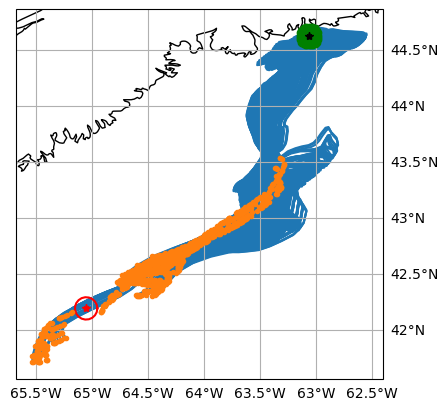

In [14]:
fig, ax = plt.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})
#ax.plot(ds['lon'].T, ds['lat'].T, transform=ccrs.PlateCarree(), color='C0')
#ds.plot.scatter(x='lon',y='lat',hue='time',  ax=ax, transform=ccrs.PlateCarree(),add_colorbar=False,add_legend=False,s=5,edgecolors='face')
#ds.isel(obs=0).plot.scatter(x='lon',y='lat',color='g',transform=ccrs.PlateCarree())
dend=ds.where((pd.to_datetime(ds.time.values)>=sight_date -datetime.timedelta(days=1))
             & (pd.to_datetime(ds.time.values) <=sight_date))
for t in ds.trajectory.values:
    d=ds.sel(trajectory=t)
    dend_t = dend.sel(trajectory=t)
    lons = np.ma.masked_greater(d.lon.values, 360)
    lats = np.ma.masked_greater(d.lat.values, 360)
    lons_sd = np.ma.masked_greater(dend_t.lon.values,360)
    lats_sd = np.ma.masked_greater(dend_t.lat.values,360)
    ax.plot(lons[~np.isnan(lons)], lats[~np.isnan(lats)], 'C0', transform=ccrs.PlateCarree())
    #ax.plot(lons[~np.isnan(lons)][-1], lats[~np.isnan(lats)][-1], '.C1', transform=ccrs.PlateCarree())
    if np.any(~np.isnan(lons_sd)):
        ax.plot(lons_sd[~np.isnan(lons_sd)], lats_sd[~np.isnan(lats_sd)], '.C1', transform=ccrs.PlateCarree(),zorder=10)
ax.gridlines(draw_labels=['bottom', 'right'])
ax.coastlines()

ax.plot(strike_lons,strike_lats, 'g.', transform=ccrs.PlateCarree())
ax.plot(strike_lon, strike_lat, 'k*', transform=ccrs.PlateCarree())
ax.plot(sight_perim_lons, sight_perim_lats, 'r-', transform=ccrs.PlateCarree())
ax.plot(sight_lon, sight_lat,
        'r*', transform=ccrs.PlateCarree())

# Backwards

In [15]:
pset = parcels.ParticleSet.from_list(
    fieldset=ocean_fieldset,
    pclass=SampleParticle,
    lon=sight_lons, 
    lat=sight_lats,
    time=sight_date
)

In [16]:
outfile="initialtest-glorys12era5-windage0.03-backwards.zarr"
output_file = pset.ParticleFile(
    name=outfile, outputdt=datetime.timedelta(hours=6)
)

In [17]:
pset.execute(
    [parcels.AdvectionRK4, wind_kernel, SampleLand, DeleteP0],
    runtime=duration,
    dt=-datetime.timedelta(minutes=15),
    output_file=output_file,
)

/home/soontiensn/repos/parcels/parcels/field.py:1564: RuntimeWarning: Sampling of velocities should normally be done using fieldset.UV or fieldset.UVW object; tread carefully
  self._check_velocitysampling()


INFO: Output files are stored in initialtest-glorys12era5-windage0.03-backwards.zarr.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2160000.0/2160000.0 [00:07<00:00, 280284.37it/s]


In [18]:
ds = xr.open_zarr(outfile)

(41.5, 45.0)

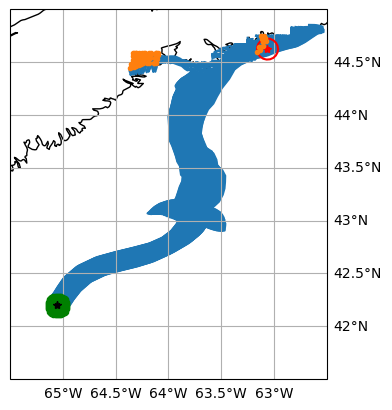

In [19]:
fig, ax = plt.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})
#ax.plot(np.ma.masked_invalid(ds['lon'].values.T), np.ma.masked_invalid(ds['lat'].values.T), transform=ccrs.PlateCarree(),color='C0')
#ds.plot.scatter(x='lon',y='lat',hue='time',  ax=ax, transform=ccrs.PlateCarree(),add_colorbar=False,add_legend=False,s=5,edgecolors='face')
#ds.isel(obs=0).plot.scatter(x='lon',y='lat',color='g',transform=ccrs.PlateCarree())
dend=ds.where((pd.to_datetime(ds.time.values)>=strike_date) & 
                  (pd.to_datetime(ds.time.values) <=strike_date +datetime.timedelta(days=1)))
for t in ds.trajectory.values:
    d=ds.sel(trajectory=t)
    dend_t  = dend.sel(trajectory=t)
    lons = np.ma.masked_greater(d.lon.values, 360)
    lats = np.ma.masked_greater(d.lat.values, 360)
    lons_sd = np.ma.masked_greater(dend_t.lon.values,360)
    lats_sd = np.ma.masked_greater(dend_t.lat.values,360)
    ax.plot(lons[~np.isnan(lons)], lats[~np.isnan(lats)], 'C0', transform=ccrs.PlateCarree())
    #ax.plot(lons[~np.isnan(lons)][-1], lats[~np.isnan(lats)][-1], '.C1', transform=ccrs.PlateCarree())
    if np.any(~np.isnan(lons_sd)):
        ax.plot(lons_sd[~np.isnan(lons_sd)], lats_sd[~np.isnan(lats_sd)], '.C1', transform=ccrs.PlateCarree(),zorder=10)
ax.gridlines(draw_labels=['bottom', 'right'])
ax.coastlines()
ax.plot(sight_lons, sight_lats, 'g.', transform=ccrs.PlateCarree())
ax.plot(sight_lon, sight_lat, 'k*', transform=ccrs.PlateCarree())
ax.plot(strike_perim_lons, strike_perim_lats, 'r-', transform=ccrs.PlateCarree())
ax.plot(strike_lon, strike_lat,
        'r*', transform=ccrs.PlateCarree())
ax.set_xlim([-65.5, -62.5])
ax.set_ylim([41.5,45])